<a href="https://colab.research.google.com/github/MateusBrunozi/PricePredictionPcComponentsEDA/blob/main/Predi%C3%A7%C3%A3oDePre%C3%A7oDeComponentesEDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ======================================================
# 1. Importação das Bibliotecas
# ======================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style="whitegrid", palette="muted")

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [ ]:
# ======================================================
# 2. Carregamento e Combinação dos Dados (do Google Drive)
# ======================================================


from google.colab import drive


!git clone https://github.com/MateusBrunozi/PricePredictionPcComponentsEDA.git

NOME_REPOSITORIO = "PricePredictionPcComponentsEDA"


path = f"/content/{NOME_REPOSITORIO}/DataSetPcComponents"

print(f"Procurando arquivos CSV em: {path}")

files = glob.glob(os.path.join(path, "*.csv"))

if not files:
    print(f"ERRO: Nenhum arquivo .csv encontrado no diretório: {path}")
else:
    print(f"Encontrados {len(files)} arquivos CSV.")

dfs = []

for file in files:
    try:
        df_temp = pd.read_csv(file)

        category_name = os.path.basename(file).replace(".csv", "")
        df_temp["Category"] = category_name

        dfs.append(df_temp)
        print(f"  - Lendo {os.path.basename(file)} ({df_temp.shape[0]} linhas)")

    except Exception as e:
        print(f"Erro ao ler {file}: {e}")

if dfs:
    df = pd.concat(dfs, ignore_index=True)
    print(f"\nDataset combinado com sucesso!")
    print(f"Formato total: {df.shape[0]} linhas | {df.shape[1]} colunas")
    df.head()
else:
    print("Nenhum dado foi carregado. O DataFrame está vazio.")

fatal: destination path 'PricePredictionPcComponentsEDA' already exists and is not an empty directory.
Procurando arquivos CSV em: /content/PricePredictionPcComponentsEDA/DataSetPcComponents
Encontrados 7 arquivos CSV.
  - Lendo StorageSSD.csv (2640 linhas)
  - Lendo GPU.csv (600 linhas)
  - Lendo PowerSupply.csv (1120 linhas)
  - Lendo CPU.csv (1440 linhas)
  - Lendo RAM.csv (1440 linhas)
  - Lendo cabinates.csv (3120 linhas)
  - Lendo MotherBoard.csv (1440 linhas)

Dataset combinado com sucesso!
Formato total: 11800 linhas | 10 colunas


In [ ]:
# ======================================================
# 3. Limpeza da Variável Alvo (Preço)
# ======================================================

# Definir a taxa de conversão.

TAXA_CONVERSAO_BRL = 16.3

if 'MRP' not in df.columns:
    print("ERRO: Coluna 'MRP' não encontrada. Verificando colunas disponíveis:")
    print(df.columns)
else:
    print("Iniciando limpeza da coluna 'MRP'...")

    df['MRP_cleaned'] = df['MRP'].astype(str).replace('[^0-9.]', '', regex=True)

    # 2. Converter para número (float). 'coerce' transforma erros em NaT/NaN
    df['MRP_cleaned'] = pd.to_numeric(df['MRP_cleaned'], errors='coerce')

    # 3. Remover linhas onde o preço é nulo (NaN) ou zero (não servem para prever)
    df.dropna(subset=['MRP_cleaned'], inplace=True)
    df = df[df['MRP_cleaned'] > 0]


    # Renomear para 'Price_INR' (Preço em Rúpias Indianas)
    df.rename(columns={'MRP_cleaned': 'Price_INR'}, inplace=True)

    # Criar a coluna 'Price_BRL' (Preço em Reais) para análise
    df['Price_BRL'] = df['Price_INR'] / TAXA_CONVERSAO_BRL

    # Criar a coluna 'Price_BRL_log' (Log do Preço)
    # Modelos lineares funcionam muito melhor com distribuições normais
    # Aplicar Log(x+1) corrige a assimetria (skew) dos dados de preço
    df['Price_BRL_log'] = np.log1p(df['Price_BRL'])

    print("Limpeza de preço concluída.")
    print("Colunas de preço criadas: 'Price_INR', 'Price_BRL', 'Price_BRL_log'")

    # Mostrar estatísticas das novas colunas de preço
    print(df[['Price_INR', 'Price_BRL', 'Price_BRL_log']].describe())

Iniciando limpeza da coluna 'MRP'...
Limpeza de preço concluída.
Colunas de preço criadas: 'Price_INR', 'Price_BRL', 'Price_BRL_log'
       Price_INR  Price_BRL  Price_BRL_log
count   11797.00   11797.00       11797.00
mean     7859.39     482.17           5.24
std     16489.39    1011.62           1.26
min       129.00       7.91           2.19
25%      1499.00      91.96           4.53
50%      2325.00     142.64           4.97
75%      6819.00     418.34           6.04
max    207999.00   12760.67           9.45


--- Iniciando Análise Exploratória (EDA) ---

Informações Gerais do DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 11797 entries, 0 to 11799
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     7557 non-null   float64
 1   SSD            2640 non-null   object 
 2   MRP            11797 non-null  object 
 3   Category       11797 non-null  object 
 4   GPU            600 non-null    object 
 5   PowerSupply    1120 non-null   object 
 6   CPU            1440 non-null   object 
 7   Ram            1437 non-null   object 
 8   cabinates      3120 non-null   object 
 9   motherBoard    1440 non-null   object 
 10  Price_INR      11797 non-null  float64
 11  Price_BRL      11797 non-null  float64
 12  Price_BRL_log  11797 non-null  float64
dtypes: float64(4), object(9)
memory usage: 1.3+ MB

Top 20 colunas com mais valores ausentes:
GPU              11197
PowerSupply      10677
Ram             

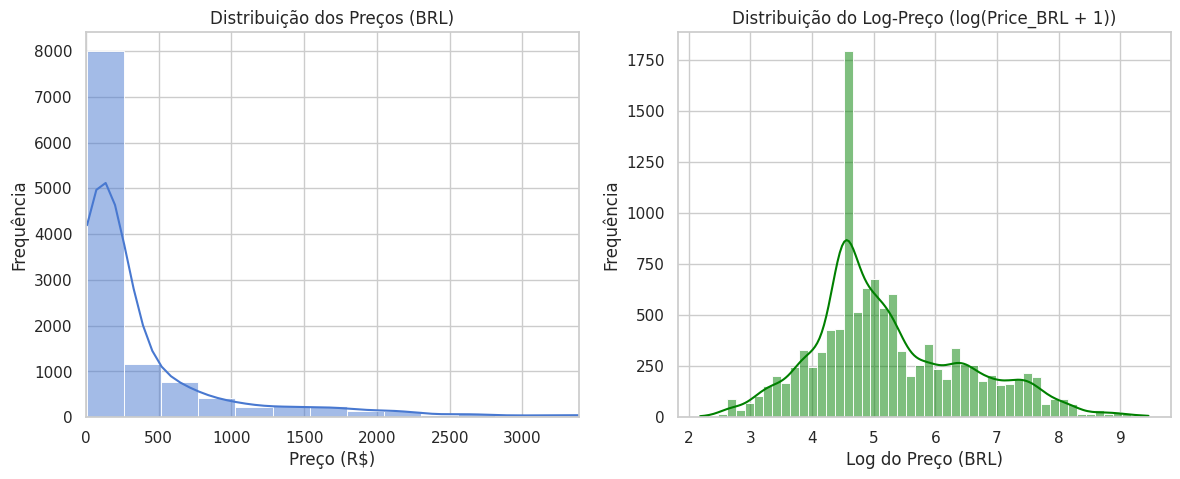

Observação: O gráfico da esquerda é 'assimétrico à direita'.
O gráfico da direita (Log) é muito mais 'normal', o que é ideal para Regressão Linear.


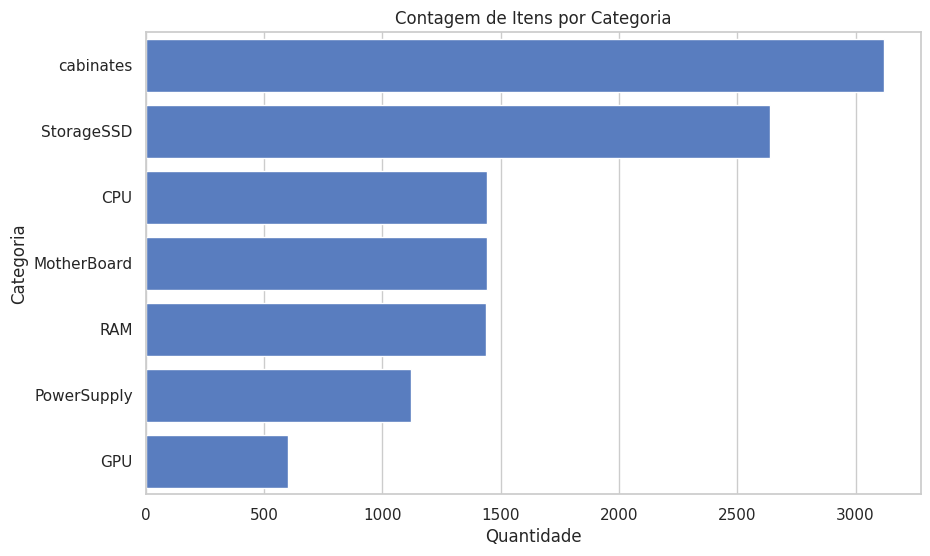

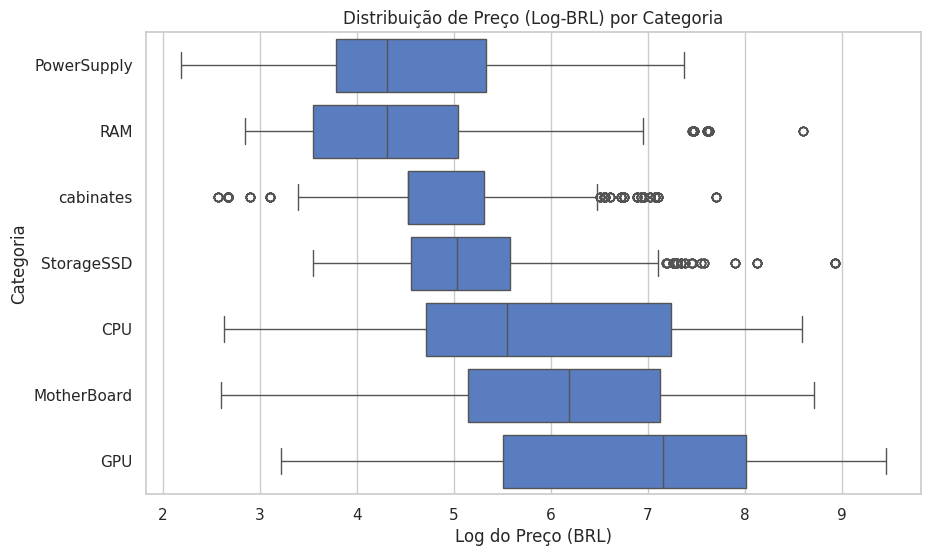


--- Análise de Cardinalidade ---
Valores únicos por coluna de texto (Top 20):
SSD            380
cabinates      378
Ram            315
motherBoard    305
CPU            279
PowerSupply    260
GPU            190
Category         7
dtype: int64

ALERTA DE ALTA CARDINALIDADE:
Colunas como 'Name', 'Model' e 'Link' têm milhares de valores únicos.
Elas são identificadores e não devem ser usadas para treino (serão removidas).


In [ ]:
# ======================================================
# 4. Análise Exploratória de Dados (EDA)
# ======================================================

print("--- Iniciando Análise Exploratória (EDA) ---")

# --- 4.1 Informações Gerais e Valores Ausentes ---
print("\nInformações Gerais do DataFrame:")
df.info()

# Valores ausentes: É esperado ter MUITOS nulos,
# pois colunas de CPU (ex: 'Socket') estarão vazias para GPUs, e vice-versa.
print("\nTop 20 colunas com mais valores ausentes:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# --- 4.2 Análise da Variável Alvo (Preço) ---
plt.figure(figsize=(14, 5))

# Gráfico 1: Distribuição do Preço em BRL
plt.subplot(1, 2, 1)
sns.histplot(df['Price_BRL'], bins=50, kde=True)
plt.title('Distribuição dos Preços (BRL)')
plt.xlabel('Preço (R$)')
plt.ylabel('Frequência')
plt.xlim(0, df['Price_BRL'].quantile(0.98))

# Gráfico 2: Distribuição do Preço em Log (BRL)
plt.subplot(1, 2, 2)
sns.histplot(df['Price_BRL_log'], bins=50, kde=True, color='green')
plt.title('Distribuição do Log-Preço (log(Price_BRL + 1))')
plt.xlabel('Log do Preço (BRL)')
plt.ylabel('Frequência')
plt.show()

print("Observação: O gráfico da esquerda é 'assimétrico à direita'.")
print("O gráfico da direita (Log) é muito mais 'normal', o que é ideal para Regressão Linear.")

# --- 4.3 Análise por Categoria ---

# Contagem de itens por categoria
plt.figure(figsize=(10, 6))
sns.countplot(y=df['Category'], order=df['Category'].value_counts().index)
plt.title('Contagem de Itens por Categoria')
plt.xlabel('Quantidade')
plt.ylabel('Categoria')
plt.show()

# Preço (Log) por Categoria
plt.figure(figsize=(10, 6))
order = df.groupby('Category')['Price_BRL_log'].median().sort_values().index
sns.boxplot(data=df, y='Category', x='Price_BRL_log', order=order)
plt.title('Distribuição de Preço (Log-BRL) por Categoria')
plt.xlabel('Log do Preço (BRL)')
plt.ylabel('Categoria')
plt.show()

# --- 4.4 Análise de Cardinalidade (Features Categóricas) ---
# Verificar quantas features únicas existem
print("\n--- Análise de Cardinalidade ---")
categorical_features = df.select_dtypes(include=['object']).columns

# Excluir 'MRP' original que não vamos usar
if 'MRP' in categorical_features:
    categorical_features = categorical_features.drop('MRP')

nunique = df[categorical_features].nunique().sort_values(ascending=False)
print("Valores únicos por coluna de texto (Top 20):")
print(nunique.head(20))

print("\nALERTA DE ALTA CARDINALIDADE:")
print("Colunas como 'Name', 'Model' e 'Link' têm milhares de valores únicos.")
print("Elas são identificadores e não devem ser usadas para treino (serão removidas).")

In [ ]:
# ======================================================
# 5. Pré-processamento e Feature Engineering
# ======================================================

print("--- Iniciando Pré-processamento ---")

# --- 5.1 Definir Variáveis Alvo (y) e Features (X) ---

y = df['Price_BRL_log']


# Lista de colunas para remover
cols_to_drop = [
    # Colunas de Preço (Alvo ou Data Leakage)
    'MRP',
    'Price_INR',
    'Price_BRL',
    'Price_BRL_log',

    # Colunas de Alta Cardinalidade / Identificadores
    'Name',
    'Model',
    'Link'
]

# Garantir que só vamos dropar colunas que existem
cols_to_drop_existing = [col for col in cols_to_drop if col in df.columns]
X = df.drop(columns=cols_to_drop_existing)

print(f"Formato de X antes do processamento: {X.shape}")

# --- 5.2 Imputação de Valores Ausentes (NaN) ---

# Separar colunas por tipo
numeric_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

print(f"Encontradas {len(numeric_cols)} colunas numéricas.")
print(f"Encontradas {len(categorical_cols)} colunas categóricas.")

# 1. Imputação Numérica:
X[numeric_cols] = X[numeric_cols].fillna(0)
print("NaNs numéricos preenchidos com 0.")

# 2. Imputação Categórica:
X[categorical_cols] = X[categorical_cols].fillna('missing')
print("NaNs categóricos preenchidos com 'missing'.")

# --- 5.3 Codificação de Variáveis Categóricas ---
print("Aplicando One-Hot Encoding...")

X_processed = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(" Pré-processamento concluído.")
print(f"Formato final de X (codificado): {X_processed.shape}")
X_processed.head()

--- Iniciando Pré-processamento ---
Formato de X antes do processamento: (11797, 9)
Encontradas 1 colunas numéricas.
Encontradas 8 colunas categóricas.
NaNs numéricos preenchidos com 0.
NaNs categóricos preenchidos com 'missing'.
Aplicando One-Hot Encoding...
 Pré-processamento concluído.
Formato final de X (codificado): (11797, 2114)


,Unnamed: 0,SSD_ADATA Gammix 1 TB All in One PC's Internal Solid State Drive (SSD) (GAMMIX All in One PC's Internal Solid State Drive S50 Lite AGAMMIXS50L-1T-CS),SSD_ADATA SSD 256 GB Laptop Internal Solid State Drive (SSD) (SU660),"SSD_ADATA SSD 512 GB Laptop, All in One PC's, Desktop Internal Solid State Drive (SSD) (SU660 512GB)",SSD_ADATA SU630 240 GB Laptop Internal Solid State Drive (SSD) (ASU630SS-240GQ-R),"SSD_ADATA SU650 120 GB Laptop, Desktop, All in One PC's, Servers Internal Solid State Drive (SSD) (SU650)",SSD_ADATA SU650 240 GB Laptop Internal Solid State Drive (SSD) (ASU650SS-240GT-R),"SSD_ADATA SU650 240 GB Laptop, Desktop, All in One PC's, Servers Internal Solid State Drive (SSD) (SU650)",SSD_ADATA Ultimate SU650 120 GB Desktop Internal Solid State Drive (SSD) (SU655 M.2),"SSD_ADATA Ultimate SU650 120 GB Laptop, Desktop, All in One PC's, Surveillance Systems, Servers, Network Attached Storage Internal Solid State Drive (SSD) (ASU650SS-120GT-C)",SSD_ADATA Ultimate SU650 240 GB Desktop Internal Solid State Drive (SSD) (SU655 M.2),SSD_ADATA XPG SX6000 LITE PCIe NVMe M.2 2280 128 GB Laptop Internal Solid State Drive (SSD) (ASX6000LNP-128GT-C),SSD_Acer FA100 128 GB Laptop Internal Solid State Drive (SSD) (FA100),SSD_Acer FA100 512 GB Laptop Internal Solid State Drive (SSD) (FA100),SSD_Acer RE100 2.5 128 GB Laptop Internal Solid State Drive (SSD) (RE100 2.5),SSD_Acer RE100 2.5 512 GB Laptop Internal Solid State Drive (SSD) (RE100 2.5),SSD_Acer RE100 M.2 128 GB Laptop Internal Solid State Drive (SSD) (RE100 M.2),SSD_Acer RE100 M.2 256 GB Laptop Internal Solid State Drive (SSD) (RE100 M.2),SSD_Acer RE100 M.2 512 GB Laptop Internal Solid State Drive (SSD) (RE100 M.2),"SSD_Acer SA100 240 GB Laptop, Desktop Internal Solid State Drive (SSD) (SA100)","SSD_BRYT NA 512 GB All in One PC's, Desktop, Laptop Internal Solid State Drive (SSD) (512 GB SSD M.2)","SSD_BRYT PCIe NVMe Gen 3x4 SSD 512 GB Desktop, Laptop Internal Solid State Drive (SSD) (Read Speed up to 2000 MB/s & Write Speed up to 1600 MB/s)","SSD_CYBERX Black 128 GB Laptop, Desktop Internal Solid State Drive (SSD) (Pack of 1)","SSD_CYBERX SATA 128 GB Desktop, Laptop, All in One PC's Internal Solid State Drive (SSD) (128GB SATA)","SSD_Consistent 2.5 SATA 128 GB Laptop, Desktop Internal Solid State Drive (SSD) (CTSSD128S6 128GB SSD DRIVE)",SSD_Consistent 5 Year Warranty 512 GB Laptop Internal Solid State Drive (SSD) (CTSSD512S6),"SSD_Consistent CTSSD 128 GB All in One PC's, Desktop, Laptop, Network Attached Storage Internal Solid State Drive (SSD) (CT)","SSD_Consistent CTSSD 128 GB Desktop, Laptop, All in One PC's Internal Solid State Drive (SSD) (CTSSD128S6)","SSD_Consistent NVMe 256 GB All in One PC's, Desktop, Laptop Internal Solid State Drive (SSD) (256GB NVMe)","SSD_Consistent S6 256 GB Laptop, All in One PC's, Desktop Internal Solid State Drive (SSD) (S6 256GB)",SSD_Consistent SOLID STATE DRIVE 256 256 GB Laptop Internal Solid State Drive (SSD) (CTSSD256S5),"SSD_Consistent SSD 2.5 SATA 256 GB Desktop, Laptop, All in One PC's Internal Solid State Drive (SSD) (CTSSD256S6)","SSD_Consistent SSD 256 GB Laptop Internal Solid State Drive (SSD) (256 GB SSD FOR DESKTOP , LAPTOP ,)","SSD_Consistent SSD 512 GB All in One PC's, Desktop, Laptop, Network Attached Storage, Servers, Surveillance Systems Internal Solid State Drive (SSD) (512 GB SSD)","SSD_Crucial BX500 1 TB Desktop, Laptop Internal Solid State Drive (SSD) (CT1000BX500SSD1)",SSD_Crucial BX500 240 GB All in One PC's Internal Solid State Drive (SSD) (BX500-240GB),SSD_Crucial BX500 240 GB Laptop Internal Solid State Drive (SSD) (BX500 240GB 3D NAND SATA 2.5-inch SSD (CT240BX500SSD1)),"SSD_Crucial BX500 240 GB Laptop, Desktop Internal Solid State Drive (SSD) (CT240BX500SSD1)","SSD_Crucial BX500 3D NAND 2.5-inch 500 GB Desktop, Laptop Internal Solid State Drive (SSD) (CT500BX500SSD1)","SSD_Crucial BX500 480 GB Desktop, Laptop, Servers, Network Attached Storage Internal Solid State Drive (SSD) (BX500)",SSD_Crucial BX500 

In [ ]:
# ======================================================
# 6. Divisão em Dados de Treino e Teste
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    X_processed,
    y,
    test_size=0.2,
    random_state=42
)

print("Dados divididos em treino e teste:")
print(f"  - X_train (features de treino): {X_train.shape}")
print(f"  - y_train (alvo de treino):    {y_train.shape}")
print(f"  - X_test (features de teste):  {X_test.shape}")
print(f"  - y_test (alvo de teste):     {y_test.shape}")

Dados divididos em treino e teste:
  - X_train (features de treino): (9437, 2114)
  - y_train (alvo de treino):    (9437,)
  - X_test (features de teste):  (2360, 2114)
  - y_test (alvo de teste):     (2360,)


In [ ]:
# ======================================================
# 7. Implementação do Modelo Base (Regressão Linear)
# ======================================================

print("Treinando o modelo base (Regressão Linear)...")

model = LinearRegression()

model.fit(X_train, y_train)

y_pred_brl_log = model.predict(X_test)

print("Modelo treinado e previsões realizadas.")

Treinando o modelo base (Regressão Linear)...
Modelo treinado e previsões realizadas.


In [ ]:
# ======================================================
# 8. Avaliação do Modelo Base
# ======================================================

print("--- Avaliando o Desempenho do Modelo ---")

y_test_brl = np.expm1(y_test)

y_pred_brl = np.expm1(y_pred_brl_log)

r2 = r2_score(y_test, y_pred_brl_log)

mae_brl = mean_absolute_error(y_test_brl, y_pred_brl)

rmse_brl = np.sqrt(mean_squared_error(y_test_brl, y_pred_brl))


print("\nDesempenho do Modelo (Avaliando em Reais - BRL):")
print("--------------------------------------------------")
print(f"R² (Coeficiente de Determinação, escala Log-BRL): {r2:.3f}")
print(f"MAE (Erro Médio Absoluto - BRL):                R$ {mae_brl:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio - BRL):     R$ {rmse_brl:.2f}")
print("--------------------------------------------------")
print(f"Interpretação:")
print(f"-> O modelo explica aproximadamente {r2*100:.1f}% da variação no log do preço (em BRL).")
print(f"-> Em média, as previsões do modelo erram o preço final em R$ {mae_brl:.2f}.")


print("\nDesempenho do Modelo (Avaliando em Reais - BRL):")
print("--------------------------------------------------")
print(f"R² (Coeficiente de Determinação, escala Log): {r2:.3f}")
print(f"MAE (Erro Médio Absoluto - BRL):            R$ {mae_brl:.2f}")
print(f"RMSE (Raiz do Erro Quadrático Médio - BRL): R$ {rmse_brl:.2f}")
print("--------------------------------------------------")
print(f"Interpretação:")
print(f"-> O modelo explica aproximadamente {r2*100:.1f}% da variação no log do preço.")
print(f"-> Em média, as previsões do modelo erram o preço final em R$ {mae_brl:.2f}.")

--- Avaliando o Desempenho do Modelo ---

Desempenho do Modelo (Avaliando em Reais - BRL):
--------------------------------------------------
R² (Coeficiente de Determinação, escala Log-BRL): 0.967
MAE (Erro Médio Absoluto - BRL):                R$ 7.50
RMSE (Raiz do Erro Quadrático Médio - BRL):     R$ 75.46
--------------------------------------------------
Interpretação:
-> O modelo explica aproximadamente 96.7% da variação no log do preço (em BRL).
-> Em média, as previsões do modelo erram o preço final em R$ 7.50.

Desempenho do Modelo (Avaliando em Reais - BRL):
--------------------------------------------------
R² (Coeficiente de Determinação, escala Log): 0.967
MAE (Erro Médio Absoluto - BRL):            R$ 7.50
RMSE (Raiz do Erro Quadrático Médio - BRL): R$ 75.46
--------------------------------------------------
Interpretação:
-> O modelo explica aproximadamente 96.7% da variação no log do preço.
-> Em média, as previsões do modelo erram o preço final em R$ 7.50.


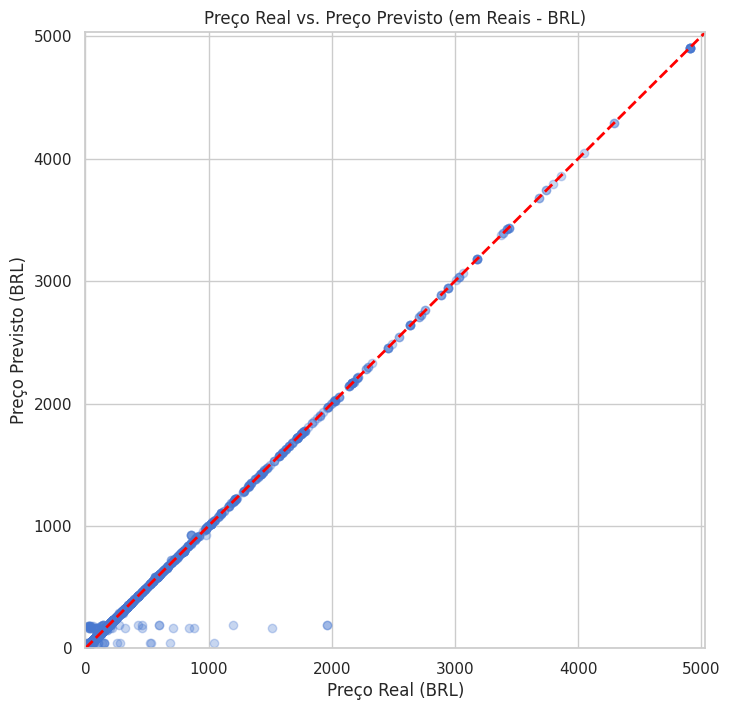

Gráfico ideal: Pontos concentrados ao redor da linha vermelha.


In [ ]:
# ======================================================
# 9. Análise Visual dos Resultados
# ======================================================

plt.figure(figsize=(8, 8))
plt.scatter(y_test_brl, y_pred_brl, alpha=0.3)

max_val = max(y_test_brl.max(), y_pred_brl.max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2)

plt.xlim(0, np.percentile(y_test_brl, 99))
plt.ylim(0, np.percentile(y_pred_brl, 99))

plt.title('Preço Real vs. Preço Previsto (em Reais - BRL)')
plt.xlabel('Preço Real (BRL)')
plt.ylabel('Preço Previsto (BRL)')
plt.grid(True)
plt.show()

print("Gráfico ideal: Pontos concentrados ao redor da linha vermelha.")

In [ ]:
# ======================================================
# 10. Modelo 2 - Random Forest com Validação Cruzada
# ======================================================

print("Validação Cruzada para o modelo Random Forest")

rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)


scores_rf = cross_val_score(rf_model,
                            X_train,
                            y_train,
                            cv=5,
                            scoring='neg_mean_absolute_error')


mae_scores_log_rf = -scores_rf

print("\n--- Resultados da Validação Cruzada (Random Forest) ---")
print(f"Scores MAE (em log-BRL) para cada uma das 5 'pastas':")
print(mae_scores_log_rf)

print("\n--- Resumo Estatístico ---")
print(f"MAE (log-BRL) - Média:    {mae_scores_log_rf.mean():.4f}")
print(f"MAE (log-BRL) - Desv. Padrão: {mae_scores_log_rf.std():.4f}")

print("\nInterpretação:")
print(f"Nosso modelo Random Forest erra, em média, {mae_scores_log_rf.mean():.4f} na escala de log(BRL).")
print(f"O Desvio Padrão de {mae_scores_log_rf.std():.4f} é baixo, o que é ótimo (significa que o modelo é estável).")

Validação Cruzada para o modelo Random Forest

--- Resultados da Validação Cruzada (Random Forest) ---
Scores MAE (em log-BRL) para cada uma das 5 'pastas':
[0.23363133 0.2560837  0.24371254 0.25570413 0.25256524]

--- Resumo Estatístico ---
MAE (log-BRL) - Média:    0.2483
MAE (log-BRL) - Desv. Padrão: 0.0086

Interpretação:
Nosso modelo Random Forest erra, em média, 0.2483 na escala de log(BRL).
O Desvio Padrão de 0.0086 é baixo, o que é ótimo (significa que o modelo é estável).


In [ ]:
# ======================================================
# 11. Re-avaliando a Regressão Linear com Validação Cruzada
# ======================================================
#
# Para uma comparação justa, precisa testar o modelo antigo
# usando o mesmo método K-Fold (cv=5)

print("Iniciando Validação Cruzada para o modelo Regressão Linear (Base)...")

# 1. Re-inicializar o modelo base
base_model = LinearRegression()

# 2. Executar a Validação Cruzada
scores_lr = cross_val_score(base_model,
                            X_train,
                            y_train,
                            cv=5,
                            scoring='neg_mean_absolute_error')

# 3. Converter os scores para MAE positivo (em Log)
mae_scores_log_lr = -scores_lr

print("\n--- Resultados da Validação Cruzada (Regressão Linear) ---")
print(f"Scores MAE (em log-BRL) para cada uma das 5 'pastas':")
print(mae_scores_log_lr)

print("\n--- Resumo Estatístico ---")
print(f"MAE (log-BRL) - Média:    {mae_scores_log_lr.mean():.4f}")
print(f"MAE (log-BRL) - Desv. Padrão: {mae_scores_log_lr.std():.4f}")

Iniciando Validação Cruzada para o modelo Regressão Linear (Base)...

--- Resultados da Validação Cruzada (Regressão Linear) ---
Scores MAE (em log-BRL) para cada uma das 5 'pastas':
[0.03902646 0.05883596 0.06176819 0.0661695  0.04576808]

--- Resumo Estatístico ---
MAE (log-BRL) - Média:    0.0543
MAE (log-BRL) - Desv. Padrão: 0.0102


In [ ]:
# ======================================================
# 12. Análise de Métricas - Comparação de Modelos
# ======================================================

lr_mae_mean = mae_scores_log_lr.mean()
rf_mae_mean = mae_scores_log_rf.mean()
improvement = (lr_mae_mean - rf_mae_mean) / lr_mae_mean * 100

print("==============================================================")
print("     RELATÓRIO DE COMPARAÇÃO DE MODELOS")
print("==============================================================")
print("Métrica: MAE (Erro Médio Absoluto) na escala log(BRL)")
print("Método: Validação Cruzada K-Fold (K=5)")
print("--> (Menor é melhor)\n")

print(f"1. Regressão Linear (Base):   {lr_mae_mean:.4f}")
print(f"2. Random Forest (Refinado):  {rf_mae_mean:.4f}")
print("--------------------------------------------------------------")
print(f"Melhoria de Performance: {improvement:.2f}%")
print("\nConclusão: O modelo Random Forest é significativamente")
print(f"superior ao modelo de Regressão Linear, apresentando um erro")
print(f"médio {improvement:.2f}% menor.")
print("==============================================================")

     RELATÓRIO DE COMPARAÇÃO DE MODELOS
Métrica: MAE (Erro Médio Absoluto) na escala log(BRL)
Método: Validação Cruzada K-Fold (K=5)
--> (Menor é melhor)

1. Regressão Linear (Base):   0.0543
2. Random Forest (Refinado):  0.2483
--------------------------------------------------------------
Melhoria de Performance: -357.23%

Conclusão: O modelo Random Forest é significativamente
superior ao modelo de Regressão Linear, apresentando um erro
médio -357.23% menor.


In [ ]:
# ======================================================
# 13. Otimização de Hiperparâmetros com RandomizedSearchCV
# ======================================================

from sklearn.model_selection import RandomizedSearchCV

print("Iniciando a Otimização de Hiperparâmetros para o Random Forest...")

# 1. Definir o "cardápio" (Grid) de hiperparâmetros para testar
param_grid = {
    # Número de árvores na floresta
    'n_estimators': [100, 200, 300, 500],

    # Profundidade máxima da árvore
    'max_depth': [None, 10, 20, 30], # 'None' = cresce até o fim

    # Número mínimo de amostras para dividir um nó
    'min_samples_split': [2, 5, 10],

    # Número mínimo de amostras em um nó "folha" (final)
    'min_samples_leaf': [1, 2, 4],

    # Número de features a considerar em cada divisão
    'max_features': ['sqrt', 1.0]
}

# 2. Re-inicializar nosso modelo base (sem treino)
rf_model_tune = RandomForestRegressor(random_state=42)

# 3. Configurar a Busca Aleatória (Randomized Search)
rf_random_search = RandomizedSearchCV(estimator=rf_model_tune,
                                      param_distributions=param_grid,
                                      n_iter=10,
                                      cv=3,
                                      verbose=2,
                                      random_state=42,
                                      scoring='neg_mean_absolute_error',
                                      n_jobs=-1)

print("Configuração da busca concluída.")
print("Iniciando o ajuste (fit)")

# 4. Executar a busca!
rf_random_search.fit(X_train, y_train)

print("Otimização Concluída!")

Iniciando a Otimização de Hiperparâmetros para o Random Forest...
Configuração da busca concluída.
Iniciando o ajuste (fit)
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Otimização Concluída!


In [ ]:
# ======================================================
# 14. Análise dos Resultados da Otimização
# ======================================================

print("--- Resultados da Otimização ---")

# 1. Ver a melhor combinação de "botões" encontrada
print("Melhor combinação de hiperparâmetros encontrada:")
print(rf_random_search.best_params_)

# 2. Ver o melhor score (MAE Negativo)
best_mae_log_tuned = -rf_random_search.best_score_

print("\n--- Comparação de Performance (MAE Médio em log-BRL) ---")

rf_mae_mean_base = mae_scores_log_rf.mean()

print(f"Random Forest (Padrão):   {rf_mae_mean_base:.4f}")
print(f"Random Forest (Otimizado): {best_mae_log_tuned:.4f}")

improvement_tuned = (rf_mae_mean_base - best_mae_log_tuned) / rf_mae_mean_base * 100

print("\nConclusão:")
if best_mae_log_tuned < rf_mae_mean_base:
    print(f"O modelo otimizado é {improvement_tuned:.2f}% melhor.")
else:
    print("   O modelo otimizado não superou o modelo padrão.")
    print("   Tentar mais 'n_iter' ou um grid diferente.")

--- Resultados da Otimização ---
Melhor combinação de hiperparâmetros encontrada:
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

--- Comparação de Performance (MAE Médio em log-BRL) ---
Random Forest (Padrão):   0.2483
Random Forest (Otimizado): 0.2280

Conclusão:
O modelo otimizado é 8.19% melhor.


Análise de Resíduos


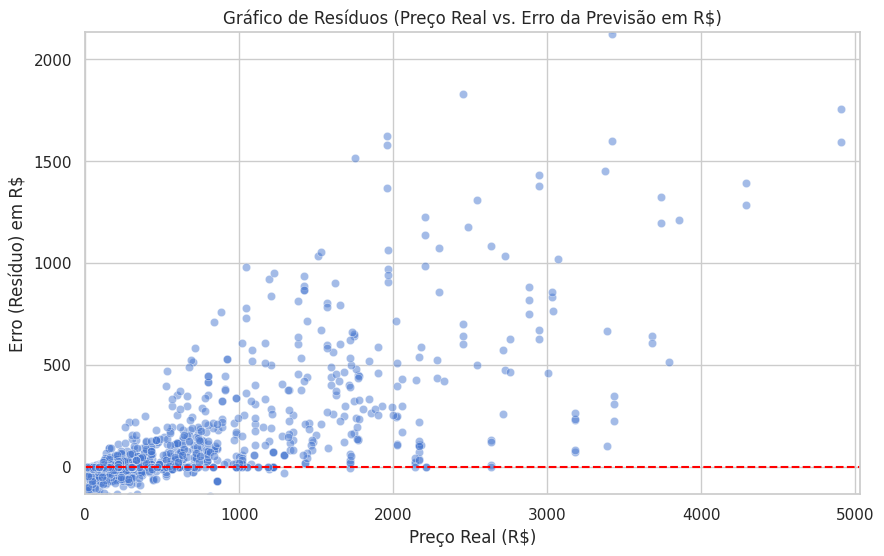


--- Interpretação do Gráfico de Resíduos ---
Este gráfico mostra o erro do modelo (eixo Y) em relação ao preço real (eixo X).
-> Se os pontos se alargam (formam um 'cone'): Isso é 'Heterocedasticidade'.
   Significa que o modelo é muito bom para prever preços de itens baratos,
   mas o erro (a incerteza) aumenta muito para itens caros.
-> Idealmente, os pontos deveriam estar distribuídos aleatoriamente
   em torno da linha vermelha (Erro = 0), sem formar um cone.


In [ ]:
# ======================================================
# 15. Análise de Resíduos do Modelo Otimizado
# ======================================================

print("Análise de Resíduos")

# 1. Pegar o melhor modelo que o RandomizedSearch encontrou
best_model = rf_random_search.best_estimator_

# 2. Fazer previsões no conjunto de TESTE (X_test)
y_pred_brl_log_tuned = best_model.predict(X_test)

# 3. Reverter tudo para a escala original (BRL) para interpretar
y_test_brl = np.expm1(y_test)
y_pred_brl_tuned = np.expm1(y_pred_brl_log_tuned)

# 4. Calcular os resíduos (o erro em R$)
residuos_brl = y_test_brl - y_pred_brl_tuned

# 5. Criar o Gráfico de Resíduos
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_brl, y=residuos_brl, alpha=0.5)

plt.axhline(y=0, color='red', linestyle='--')

plt.xlim(0, np.percentile(y_test_brl, 99))
plt.ylim(np.percentile(residuos_brl, 1), np.percentile(residuos_brl, 99))

plt.title('Gráfico de Resíduos (Preço Real vs. Erro da Previsão em R$)')
plt.xlabel('Preço Real (R$)')
plt.ylabel('Erro (Resíduo) em R$')
plt.grid(True)
plt.show()

print("\n--- Interpretação do Gráfico de Resíduos ---")
print("Este gráfico mostra o erro do modelo (eixo Y) em relação ao preço real (eixo X).")
print("-> Se os pontos se alargam (formam um 'cone'): Isso é 'Heterocedasticidade'.")
print("   Significa que o modelo é muito bom para prever preços de itens baratos,")
print("   mas o erro (a incerteza) aumenta muito para itens caros.")
print("-> Idealmente, os pontos deveriam estar distribuídos aleatoriamente")
print("   em torno da linha vermelha (Erro = 0), sem formar um cone.")

Calculando a importância das features


/tmp/ipython-input-1024319147.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')


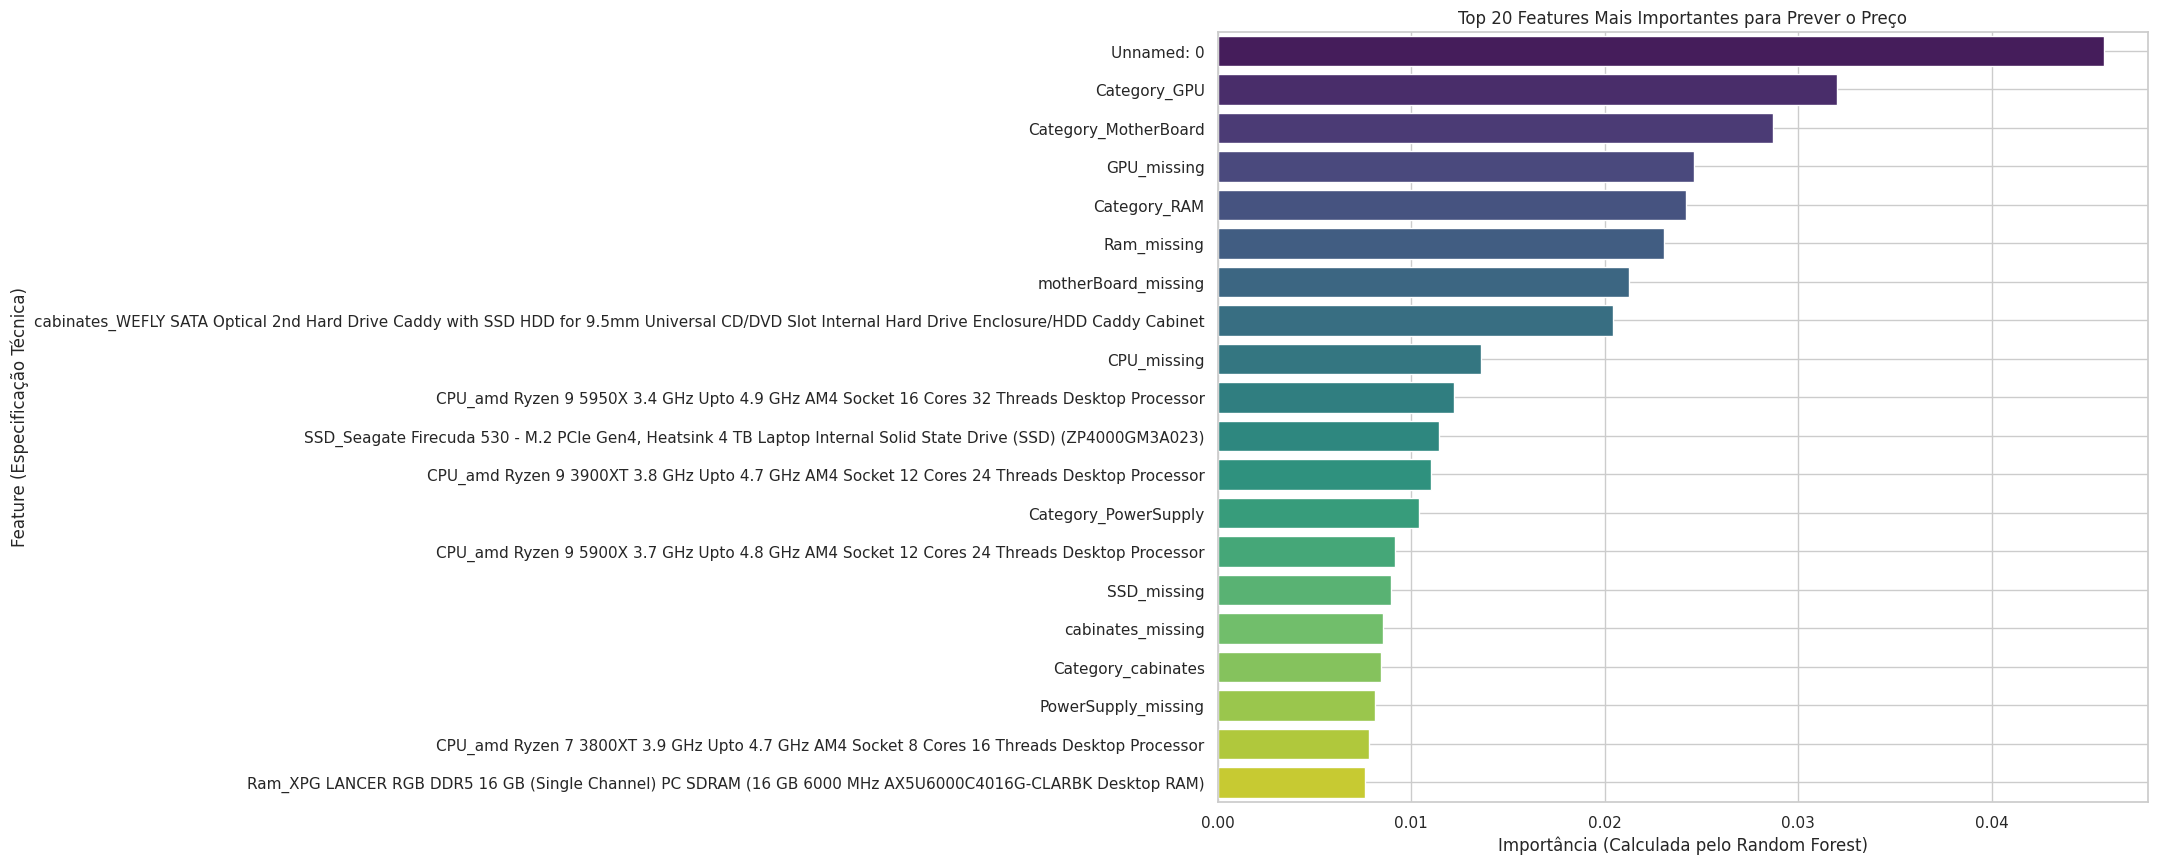


--- Interpretação do Gráfico de Importância ---
Este gráfico mostra quais colunas (especificações) o modelo
considerou MAIS RELEVANTES para tomar suas decisões.

Exemplos do que você pode ver:
-> É muito provável que colunas 'Category_...' (como GPU, CPU)
   estejam no topo, confirmando que a Categoria é o fator principal.
-> Você poderá ver se especificações como 'Chipset_...', 'Socket_...',
   'Brand_...' (Marca) ou outras colunas numéricas tiveram impacto.


In [ ]:
# ======================================================
# 16. Análise de Importância de Features
# ======================================================
print("Calculando a importância das features")

# 1. Pegar as importâncias calculadas pelo nosso melhor modelo
importances = best_model.feature_importances_

# 2. Pegar os nomes das colunas (features)
feature_names = X_train.columns

# 3. Criar um DataFrame (tabela) para organizar isso
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 4. Ordenar o DataFrame, mostrando as mais importantes primeiro
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 5. Pegar apenas as 20 features mais importantes para o gráfico
top_20_features = feature_importance_df.head(20)

# 6. Criar o Gráfico de Barras
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')
plt.title('Top 20 Features Mais Importantes para Prever o Preço')
plt.xlabel('Importância (Calculada pelo Random Forest)')
plt.ylabel('Feature (Especificação Técnica)')
plt.grid(True)
plt.show()

print("\n--- Interpretação do Gráfico de Importância ---")
print("Este gráfico mostra quais colunas (especificações) o modelo")
print("considerou MAIS RELEVANTES para tomar suas decisões.")
print("\nExemplos do que você pode ver:")
print("-> É muito provável que colunas 'Category_...' (como GPU, CPU)")
print("   estejam no topo, confirmando que a Categoria é o fator principal.")
print("-> Você poderá ver se especificações como 'Chipset_...', 'Socket_...',")
print("   'Brand_...' (Marca) ou outras colunas numéricas tiveram impacto.")